In [1]:
import pandas as pd
import keras
from IPython.display import display, HTML
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import datetime
from keras.layers import Dense,Dropout,BatchNormalization,LSTM,GRU,SimpleRNN,Activation
from keras.regularizers import L1L2

np.random.seed(42)

Using TensorFlow backend.


In [2]:
from math import pi
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

output_notebook()

Loading BokehJS ...

In [4]:
HOURS_IN_DAY = 24
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
AGGREGATION_PERIOD = 30 #Model uses 30 minutes candles

DAY_WINDOW = int(HOURS_IN_DAY * MINUTES_IN_HOUR / AGGREGATION_PERIOD)

In [5]:
# Force CPU usage
import tensorflow as tf
from keras import backend as K

num_cores = 8

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [113]:
# For plot

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [7]:
def aggregate_market_values(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
    
    data = data.groupby(data.Timestamp // aggregation_factor).agg({
        'Open' : 'first',
        'High' : np.max,
        'Low' : np.min,
        'Close' : 'last',
        'Volume_(BTC)' : np.sum ,
        'Volume_(Currency)' : np.sum,
        'Weighted_Price' : np.mean,
    }).reset_index()
    
    data.Timestamp *= aggregation_factor
    
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data

def first_in_window(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
            
    data = data.groupby(data.Timestamp // aggregation_factor).first().reset_index(drop=True)
            
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data
    

In [8]:
df_raw_part1 = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df_raw_part2 = pd.read_csv('Data/bitstampUSD_30-min_data_january.csv', date_parser=True)

# Aggregate first part of data into chunks of 30 mins, second part already aggregated
df_p1 = aggregate_market_values(df_raw_part1, 30, unix_time=True)
df_p1.Timestamp = pd.to_datetime(df_p1.Timestamp, unit='s')

df_p2 = df_raw_part2
df_p2.Timestamp = pd.to_datetime(df_p2.Timestamp)

df_raw = pd.concat([df_p1, df_p2]).reset_index(drop=True)

display(df_raw[105370:105372])
display(df_raw.tail())
print(df_raw.dtypes)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
105370,2018-01-08 00:00:00,16173.98,16176.96,16102.05,16166.78,25.633791,4.132784e+05,16122.40664
105371,2018-01-08 00:30:00,16293.99,16300.00,15954.16,15956.66,221.650000,3.577715e+06,16140.98000


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
108615,2018-03-16 14:30:00,8503.41,8505.00,8435.94,8453.20,250.99,2126237.50,8471.47
108616,2018-03-16 15:00:00,8452.99,8527.24,8450.10,8511.47,321.19,2727121.08,8490.73
108617,2018-03-16 15:30:00,8510.00,8613.06,8482.47,8554.04,563.11,4813543.76,8548.16
108618,2018-03-16 16:00:00,8554.42,8572.28,8472.24,8541.17,305.72,2605758.19,8523.24
108619,2018-03-16 16:30:00,8547.41,8553.83,8522.02,8541.19,30.78,262893.41,8539.96


Timestamp            datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
dtype: object


In [9]:
df_plot = df_raw.copy()

aggregation_factor = 24 * 60 #24h candles

df_plot = aggregate_market_values(df_plot, 12 * 60)

inc = df_plot.Close >= df_plot.Open
dec = df_plot.Open > df_plot.Close
barWidth = 0.66 * aggregation_factor * 60 * 1000 # 30 minutes in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df_plot.Timestamp, df_plot.High, df_plot.Timestamp, df_plot.Low, color="black")
p.vbar(df_plot.Timestamp[inc], barWidth, df_plot.Open[inc], df_plot.Close[inc], fill_color="#48D922", line_color="black")
p.vbar(df_plot.Timestamp[dec], barWidth, df_plot.Open[dec], df_plot.Close[dec], fill_color="#FF2828", line_color="black")

show(p)

In [12]:
def add_prices_n_periods_ago(data, periods, step=DAY_WINDOW):
    return data['Smoothed_Price'].copy().shift(step * periods)

def dummy_increased_since(data, periods, step=DAY_WINDOW):
    return 1 * (data['Smoothed_Price'] > data['Smoothed_Price'].shift(int(step * periods)))

def mean_square_loss(predicted_labels, true_labels):
    assert len(predicted_labels) == len(true_labels)
    return np.mean((predicted_labels - true_labels)**2)

def accuracy(x,y):
    return np.mean(x==y)

In [13]:
SMOOTHING_PERIOD = int(0.25 * 2 * 24) # 3h

df_processed = df_raw.copy()
df_processed['Smoothed_Price'] = (0.5 * (df_processed.Close + df_processed.Open)).rolling(SMOOTHING_PERIOD).mean()
df_processed['Inc_1_day'] = dummy_increased_since(df_processed, 1)
df_processed['Inc_12_hours'] = dummy_increased_since(df_processed, 0.5)
df_processed['Inc_6_hour'] = dummy_increased_since(df_processed, 0.25)
df_processed['Inc_3_hour'] = dummy_increased_since(df_processed, 0.125)
df_processed = df_processed.dropna(how='any')
display(df_processed.head(1))

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour
11,2011-12-31 13:00:00,4.39,4.39,4.39,4.39,13.667426,60.000001,4.39,4.39,0,0,0,0


In [15]:
last_n_points = 10000

p = figure(x_axis_type="datetime",  plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.line(df_processed.Timestamp[-last_n_points:], df_processed.Open[-last_n_points:], line_alpha=0.6, line_color="black")
p.line(df_processed.Timestamp[-last_n_points:], df_processed.Smoothed_Price[-last_n_points:], line_alpha=1, line_color="red", legend=("Rolling avg. "+str(SMOOTHING_PERIOD)))

display(df_processed.head(1))
show(p)

p = figure(x_axis_type="datetime",  plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.line(df_processed.Timestamp[-last_n_points:], df_processed.Inc_1_day[-last_n_points:], line_alpha=1, line_color="#0000FF", legend="increase since 24h")
p.line(df_processed.Timestamp[-last_n_points:], df_processed.Inc_12_hours[-last_n_points:], line_alpha=1, line_color="#FF0000", legend="increase since 12h")

display(df_processed.head(1))
show(p)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour
11,2011-12-31 13:00:00,4.39,4.39,4.39,4.39,13.667426,60.000001,4.39,4.39,0,0,0,0


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour
11,2011-12-31 13:00:00,4.39,4.39,4.39,4.39,13.667426,60.000001,4.39,4.39,0,0,0,0


In [75]:
def split_dataset(data, fraction):
    l = len(data)
    
    train = data[0 : int(l * fraction)]
    test = data[ int(l*fraction) :]
    
    return train, test

NORMALIZE = True
ADD_PRICE_N_AGO = False
ADD_MA_N_AGO = False
LOG = False

df = df_processed.copy()
df['Label'] = create_labels(df, step_size = DAY_WINDOW*2)
df = df.dropna()

if LOG:
    df.Smoothed_Price = df.Smoothed_Price.apply(lambda x: np.log(x))
if ADD_PRICE_N_AGO:
    for i in range(1,31):
        add_prices_n_periods_ago(i, step=4)
if ADD_MA_N_AGO:
    add_MA_n_days_age(5)
    add_MA_n_days_age(10)
    add_MA_n_days_age(15)

if NORMALIZE:
    timestamps = df.Timestamp
    labels = df.Label
    df = df.drop('Timestamp',1)
    df = (df-df.mean())/df.std()
    df.Label = labels
    df['Timestamp'] = timestamps
    print("Standardized input data")
    display(df.describe())


train, test = split_dataset(df, 0.9)
train_x = train.drop('Label',1)
train_y = train['Label']
train_bin = train_y > 0
test_x = test.drop('Label',1)
test_y = test['Label']
test_bin = test_y > 0


display(train.head())
display(test.head())

Standardized input data


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour,Label
count,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,1.085130e+05,108513.000000
mean,-3.250638e-15,7.357963e-15,-2.845935e-15,6.072591e-15,2.512675e-15,2.633932e-15,-1.011575e-15,3.492775e-15,2.957403e-15,1.885565e-14,2.766537e-14,1.073844e-14,7.241351
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,281.657505
min,-4.474665e-01,-4.468492e-01,-4.491391e-01,-4.474811e-01,-5.605427e-01,-2.970924e-01,-4.474989e-01,-4.474273e-01,-1.123806e+00,-1.105163e+00,-1.087940e+00,-1.072717e+00,-4219.987917
25%,-4.065994e-01,-4.060818e-01,-4.072597e-01,-4.066223e-01,-4.276973e-01,-2.876512e-01,-4.066131e-01,-4.065659e-01,-1.123806e+00,-1.105163e+00,-1.087940e+00,-1.072717e+00,-4.350833
50%,-3.071306e-01,-3.069234e-01,-3.075946e-01,-3.071886e-01,-2.709543e-01,-2.597615e-01,-3.071539e-01,-3.071078e-01,8.898255e-01,9.048355e-01,9.191601e-01,9.322041e-01,0.270417
75%,-1.932776e-01,-1.932487e-01,-1.930353e-01,-1.932447e-01,5.202938e-02,-1.608766e-01,-1.934137e-01,-1.934180e-01,8.898255e-01,9.048355e-01,9.191601e-01,9.322041e-01,9.489167
max,6.637082e+00,6.600466e+00,6.652832e+00,6.627390e+00,7.875874e+01,3.775688e+01,6.637105e+00,6.577592e+00,8.898255e-01,9.048355e-01,9.191601e-01,9.322041e-01,4510.541667


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour,Label,Timestamp
11,-0.447376,-0.44676,-0.448087,-0.447391,-0.537718,-0.297048,-0.447409,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717,0.61,2011-12-31 13:00:00
12,-0.447376,-0.44676,-0.448087,-0.447391,-0.537718,-0.297048,-0.447409,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717,0.61,2011-12-31 13:30:00
13,-0.447376,-0.44676,-0.448087,-0.447391,-0.537718,-0.297048,-0.447409,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717,0.61,2011-12-31 14:00:00
14,-0.447376,-0.44676,-0.448087,-0.447391,-0.537718,-0.297048,-0.447409,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717,0.61,2011-12-31 14:30:00
15,-0.447376,-0.44676,-0.448087,-0.447391,-0.537718,-0.297048,-0.447409,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717,0.61,2011-12-31 15:00:00


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour,Label,Timestamp
97672,0.538481,0.539294,0.545327,0.545686,-0.017140,0.373849,0.542588,0.544748,0.889825,0.904836,0.91916,0.932204,-34.648333,2017-07-31 15:00:00
97673,0.545453,0.543660,0.548750,0.548001,-0.114936,0.255468,0.548195,0.546051,0.889825,0.904836,0.91916,0.932204,-40.894167,2017-07-31 15:30:00
97674,0.548698,0.547922,0.554979,0.554478,-0.343983,-0.027712,0.550143,0.547776,0.889825,0.904836,0.91916,0.932204,-47.500417,2017-07-31 16:00:00
97675,0.552533,0.549882,0.555787,0.552171,-0.159660,0.202602,0.552355,0.549237,0.889825,0.904836,0.91916,0.932204,-52.361250,2017-07-31 16:30:00
97676,0.550446,0.547015,0.558095,0.551156,-0.414581,-0.115159,0.552050,0.550069,0.889825,0.904836,0.91916,0.932204,-55.669583,2017-07-31 17:00:00


# LSTM

In [23]:
to_drop = ['Timestamp', 'Open', 'Close', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price', 'Volume_(Currency)']
train_x_nn = train_x.copy().drop(to_drop,1)
test_x_nn = test_x.copy().drop(to_drop,1)

train_y_nn = (train_y > 0).astype(int)
test_y_nn = (test_y > 0).astype(int)


print("% of 1 in train: " + str(np.sum(train_y_nn == 1) / len(train_y)))
print("% of 1 in test: " + str(np.sum(test_y_nn == 1) / len(test_y)))
print(test_y_nn.dtypes)
display(train_x_nn.head())
display(train_y_nn.head())

% of 1 in train: 0.570821515241
% of 1 in test: 0.598967932178
int32


,Smoothed_Price,Inc_1_day,Inc_12_hours,Inc_6_hour,Inc_3_hour
11,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717
12,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717
13,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717
14,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717
15,-0.447363,-1.123806,-1.105163,-1.08794,-1.072717


11    1
12    1
13    1
14    1
15    1
Name: Label, dtype: int32

### Create the new dataset

We first create the new dataset by concatenating n datapoints into a single one. The y will be calculated by taking the price of the last datapoint and comparing it to the next one. 

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 1:]
        dataX.append(a)
        dataY.append((dataset[i + look_back -1, 0] > dataset[i + look_back, 0])*1)
    return np.array(dataX), np.array(dataY)

In [97]:
train_test = np.asarray([[1,2,0],[2,3,1000],[1,5,-10],[4,7,1],[2,3,20],[4,9,10],[100,9,10]])
trainX_test, trainY_test = create_dataset(train_test, look_back = 2)

print(trainX_test)
print(trainY_test)

[[[   2    0]
  [   3 1000]]

 [[   3 1000]
  [   5  -10]]

 [[   5  -10]
  [   7    1]]

 [[   7    1]
  [   3   20]]]
[1 0 1 0]


In [25]:
import random

def downsample(x,y):
    print("Ratio: " + str(y.sum()/y.shape[0]))
    numberOf1 = y.sum()
    numberOf0 = y.shape - y.sum()
    minNumber = min(numberOf0,numberOf1)

    indexes = np.asarray(random.sample(list(np.where(y == 0)[0]), minNumber) + 
                         random.sample(list(np.where(y == 1)[0]), minNumber))
    indexes.sort()
    y_downsample = y.take(indexes)
    x_downsample = x.take(indexes,0)
        
    print("Downsample Ratio: " + str(y_downsample.sum()/y_downsample.shape[0]))

    return x_downsample,y_downsample

In [87]:
def create_x_y(look_back = 16,batch_size = 869):
    trainX, trainY = create_dataset(train_x_nn.values, look_back)
    testX, testY = create_dataset(test_x_nn.values, look_back)
    trainX_downsample, trainY_downsample = downsample(trainX,trainY)
    testX_downsample, testY_downsample = downsample(testX,testY)
    testX_downsample = testX_downsample[:batch_size*10,:,:]
    testY_downsample= testY_downsample[:batch_size*10]

    print(trainX_downsample.shape)
    print(trainY_downsample.shape)
    
    return trainX_downsample, trainY_downsample,testX_downsample, testY_downsample

## 3 hours look back

In [115]:
batch_size = 869

In [116]:
look_back = 1
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.453813780604
Downsample Ratio: 0.5
Ratio: 0.449400921659
Downsample Ratio: 0.5
(88638, 1, 4)
(88638,)


In [117]:
# create and fit the LSTM network
model_3hours = Sequential()
model_3hours.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model_3hours.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_3hours.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_3hours.add(Dense(1, activation='sigmoid'))
model_3hours.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_3hours = model_3hours.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 18s 201us/step - loss: 1.6845 - acc: 0.5065 - val_loss: 0.7780 - val_acc: 0.5036
Epoch 2/30
88638/88638 [==============================] - 12s 134us/step - loss: 0.7113 - acc: 0.4987 - val_loss: 0.6936 - val_acc: 0.4964
Epoch 3/30
88638/88638 [==============================] - 15s 168us/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4964
Epoch 4/30
88638/88638 [==============================] - 12s 139us/step - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 5/30
88638/88638 [==============================] - 12s 137us/step - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.4964
Epoch 6/30
88638/88638 [==============================] - 13s 151us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 7/30
88638/88638 [==============================] - 14s 154us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6

## 1 day look back

In [132]:
look_back = 8
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.453846311391
Downsample Ratio: 0.5
Ratio: 0.449691044914
Downsample Ratio: 0.5
(88638, 8, 4)
(88638,)


In [133]:
# create and fit the LSTM network
model_1day = Sequential()
model_1day.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model_1day.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_1day.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_1day.add(Dense(1, activation='sigmoid'))
model_1day.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_1day = model_1day.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 102s 1ms/step - loss: 1.6763 - acc: 0.6306 - val_loss: 0.6966 - val_acc: 0.7128
Epoch 2/30
88638/88638 [==============================] - 96s 1ms/step - loss: 0.6100 - acc: 0.7407 - val_loss: 0.5352 - val_acc: 0.7872
Epoch 3/30
88638/88638 [==============================] - 94s 1ms/step - loss: 0.5594 - acc: 0.7613 - val_loss: 0.5179 - val_acc: 0.7880
Epoch 4/30
88638/88638 [==============================] - 93s 1ms/step - loss: 0.5550 - acc: 0.7615 - val_loss: 0.5175 - val_acc: 0.7884
Epoch 5/30
88638/88638 [==============================] - 95s 1ms/step - loss: 0.5529 - acc: 0.7617 - val_loss: 0.5157 - val_acc: 0.7885
Epoch 6/30
88638/88638 [==============================] - 96s 1ms/step - loss: 0.5521 - acc: 0.7615 - val_loss: 0.5146 - val_acc: 0.7885
Epoch 7/30
88638/88638 [==============================] - 96s 1ms/step - loss: 0.5504 - acc: 0.7618 - val_loss: 0.5101 - val_acc

## 2 days look back: different regularization

In [80]:
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(16)

Ratio: 0.453883495146
Downsample Ratio: 0.5
Ratio: 0.450023073373
Downsample Ratio: 0.5
(88638, 16, 4)
(88638,)


In [38]:
# create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(Dense(1, activation='sigmoid'))t
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history1 = model1.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 80s 905us/step - loss: 1.6654 - acc: 0.6387 - val_loss: 0.6829 - val_acc: 0.7299
Epoch 2/30
88638/88638 [==============================] - 78s 879us/step - loss: 0.5947 - acc: 0.7502 - val_loss: 0.5198 - val_acc: 0.7871
Epoch 3/30
88638/88638 [==============================] - 77s 873us/step - loss: 0.5553 - acc: 0.7612 - val_loss: 0.5152 - val_acc: 0.7869
Epoch 4/30
88638/88638 [==============================] - 79s 886us/step - loss: 0.5540 - acc: 0.7611 - val_loss: 0.5160 - val_acc: 0.7868
Epoch 5/30
88638/88638 [==============================] - 78s 884us/step - loss: 0.5496 - acc: 0.7613 - val_loss: 0.5148 - val_acc: 0.7871
Epoch 6/30
88638/88638 [==============================] - 79s 889us/step - loss: 0.5474 - acc: 0.7613 - val_loss: 0.5124 - val_acc: 0.7871
Epoch 7/30
88638/88638 [==============================] - 79s 888us/step - loss: 0.5452 - acc: 0.7617 - val_loss: 0.5

In [39]:
model2 = Sequential()
model2.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True))
model2.add(Dropout(0.6))
model2.add(LSTM(100, return_sequences=True, stateful=True))
model2.add(Dropout(0.6))
model2.add(LSTM(100, stateful=True))
model2.add(Dropout(0.6))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history2 = model2.fit(trainX_downsample, trainY_downsample, epochs= 30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 106s 1ms/step - loss: 0.6033 - acc: 0.6877 - val_loss: 0.5203 - val_acc: 0.7730
Epoch 2/30
88638/88638 [==============================] - 102s 1ms/step - loss: 0.5519 - acc: 0.7500 - val_loss: 0.4976 - val_acc: 0.7860
Epoch 3/30
88638/88638 [==============================] - 102s 1ms/step - loss: 0.5409 - acc: 0.7598 - val_loss: 0.4932 - val_acc: 0.7869
Epoch 4/30
88638/88638 [==============================] - 102s 1ms/step - loss: 0.5353 - acc: 0.7613 - val_loss: 0.4923 - val_acc: 0.7870
Epoch 5/30
88638/88638 [==============================] - 103s 1ms/step - loss: 0.5342 - acc: 0.7605 - val_loss: 0.4862 - val_acc: 0.7877
Epoch 6/30
88638/88638 [==============================] - 106s 1ms/step - loss: 0.5322 - acc: 0.7611 - val_loss: 0.4894 - val_acc: 0.7873
Epoch 7/30
88638/88638 [==============================] - 105s 1ms/step - loss: 0.5303 - acc: 0.7613 - val_loss: 0.4843 - v

In [40]:
# create and fit the LSTM network
model3 = Sequential()
model3.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True))
model3.add(LSTM(100, return_sequences=True, stateful=True))
model3.add(Dropout(0.7))
model3.add(LSTM(100, stateful=True))
model3.add(Dropout(0.7))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history3 = model3.fit(trainX_downsample, trainY_downsample, epochs= 30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 108s 1ms/step - loss: 0.6036 - acc: 0.6887 - val_loss: 0.5189 - val_acc: 0.7674
Epoch 2/30
88638/88638 [==============================] - 104s 1ms/step - loss: 0.5451 - acc: 0.7569 - val_loss: 0.4912 - val_acc: 0.7872
Epoch 3/30
88638/88638 [==============================] - 105s 1ms/step - loss: 0.5338 - acc: 0.7615 - val_loss: 0.4866 - val_acc: 0.7871
Epoch 4/30
88638/88638 [==============================] - 104s 1ms/step - loss: 0.5311 - acc: 0.7619 - val_loss: 0.4882 - val_acc: 0.7873
Epoch 5/30
88638/88638 [==============================] - 104s 1ms/step - loss: 0.5290 - acc: 0.7618 - val_loss: 0.4856 - val_acc: 0.7872
Epoch 6/30
88638/88638 [==============================] - 104s 1ms/step - loss: 0.5274 - acc: 0.7614 - val_loss: 0.4842 - val_acc: 0.7875
Epoch 7/30
88638/88638 [==============================] - 104s 1ms/step - loss: 0.5271 - acc: 0.7620 - val_loss: 0.4836 - v

In [66]:
# create and fit the LSTM network
model4 = Sequential()
model4.add(LSTM(100, batch_input_shape=(batch_size,look_back,4), return_sequences=True,kernel_regularizer = L1L2(l2=0.005)))
model4.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.005)))
model4.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.005)))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history4 = model4.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 88638 samples, validate on 8690 samples
Epoch 1/30
88638/88638 [==============================] - 125s 1ms/step - loss: 1.1353 - acc: 0.6704 - val_loss: 0.5810 - val_acc: 0.7861
Epoch 2/30
88638/88638 [==============================] - 124s 1ms/step - loss: 0.5637 - acc: 0.7617 - val_loss: 0.5069 - val_acc: 0.7900
Epoch 3/30
88638/88638 [==============================] - 121s 1ms/step - loss: 0.5434 - acc: 0.7620 - val_loss: 0.5038 - val_acc: 0.7903
Epoch 4/30
88638/88638 [==============================] - 119s 1ms/step - loss: 0.5393 - acc: 0.7624 - val_loss: 0.5002 - val_acc: 0.7901
Epoch 5/30
88638/88638 [==============================] - 121s 1ms/step - loss: 0.5395 - acc: 0.7622 - val_loss: 0.5015 - val_acc: 0.7904
Epoch 6/30
88638/88638 [==============================] - 120s 1ms/step - loss: 0.5356 - acc: 0.7626 - val_loss: 0.4934 - val_acc: 0.7899
Epoch 7/30
88638/88638 [==============================] - 120s 1ms/step - loss: 0.5343 - acc: 0.7625 - val_loss: 0.4931 - v

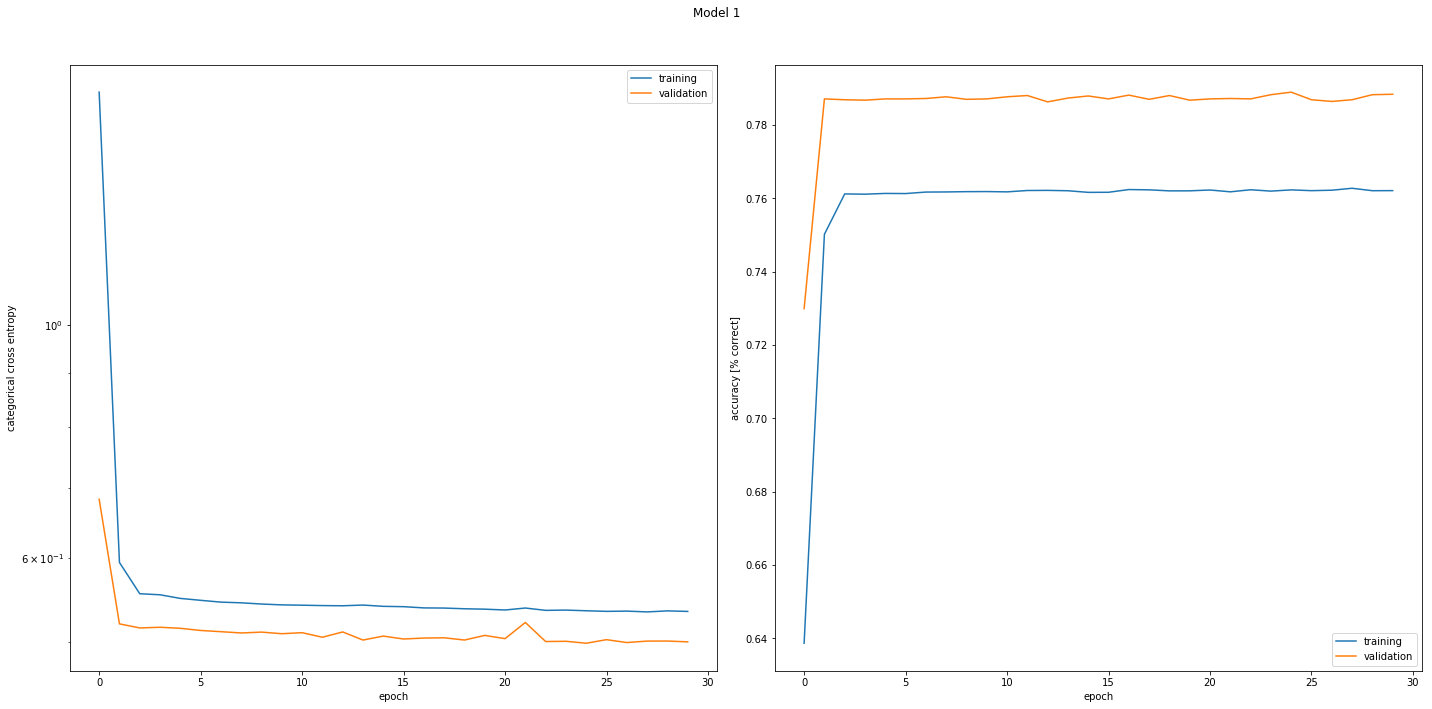

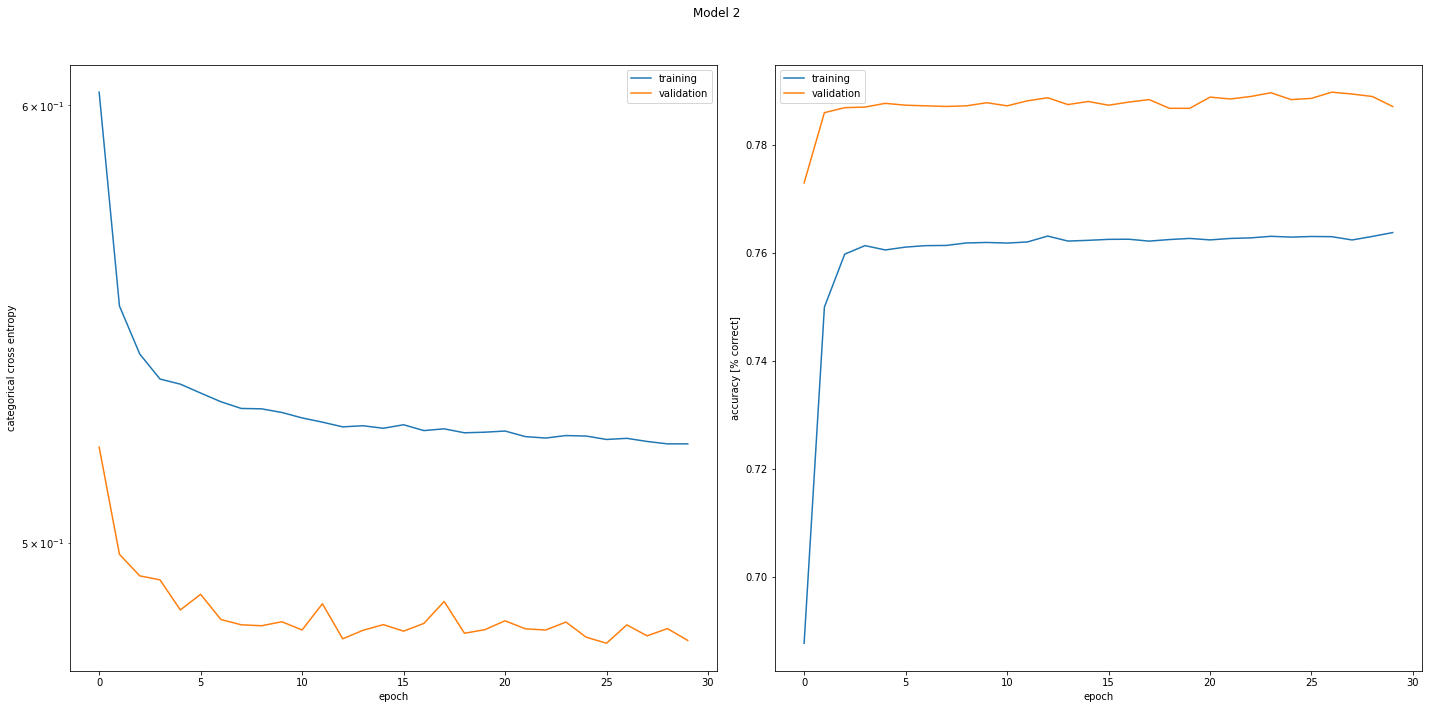

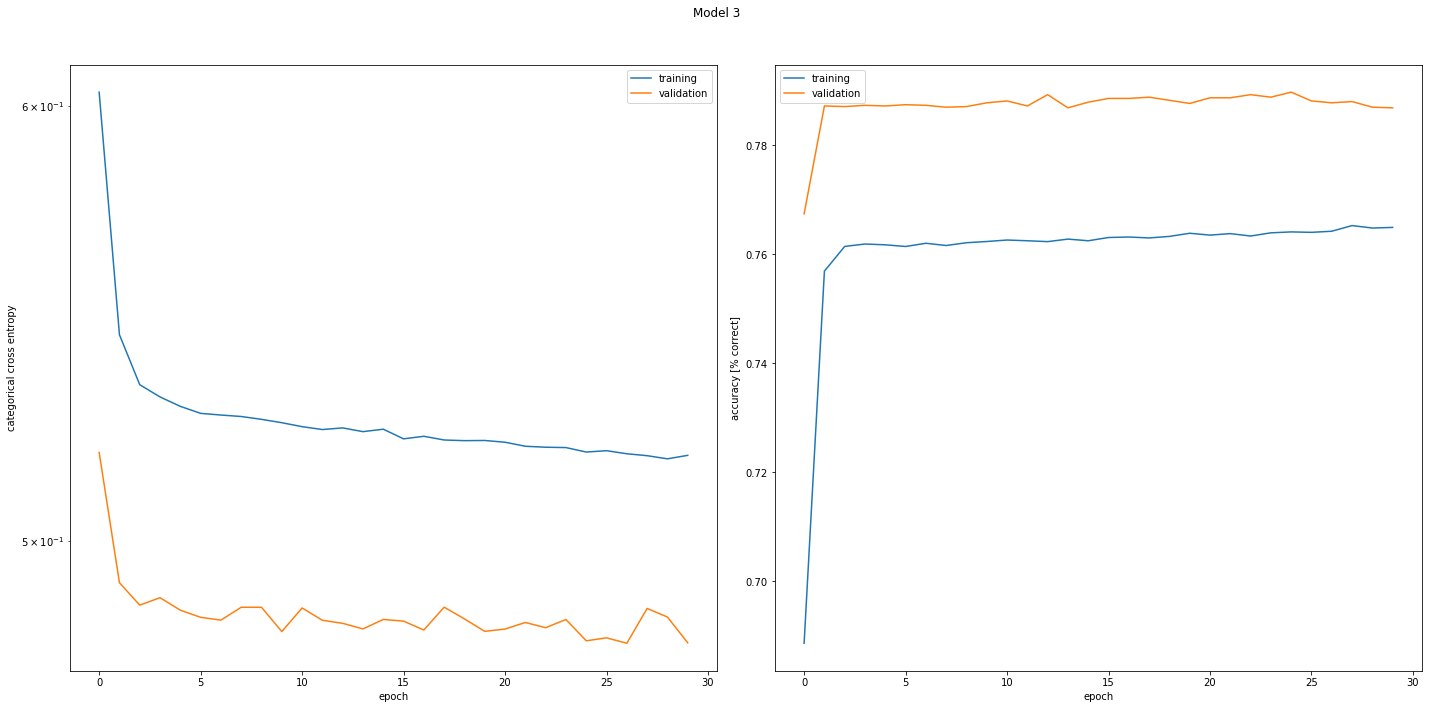

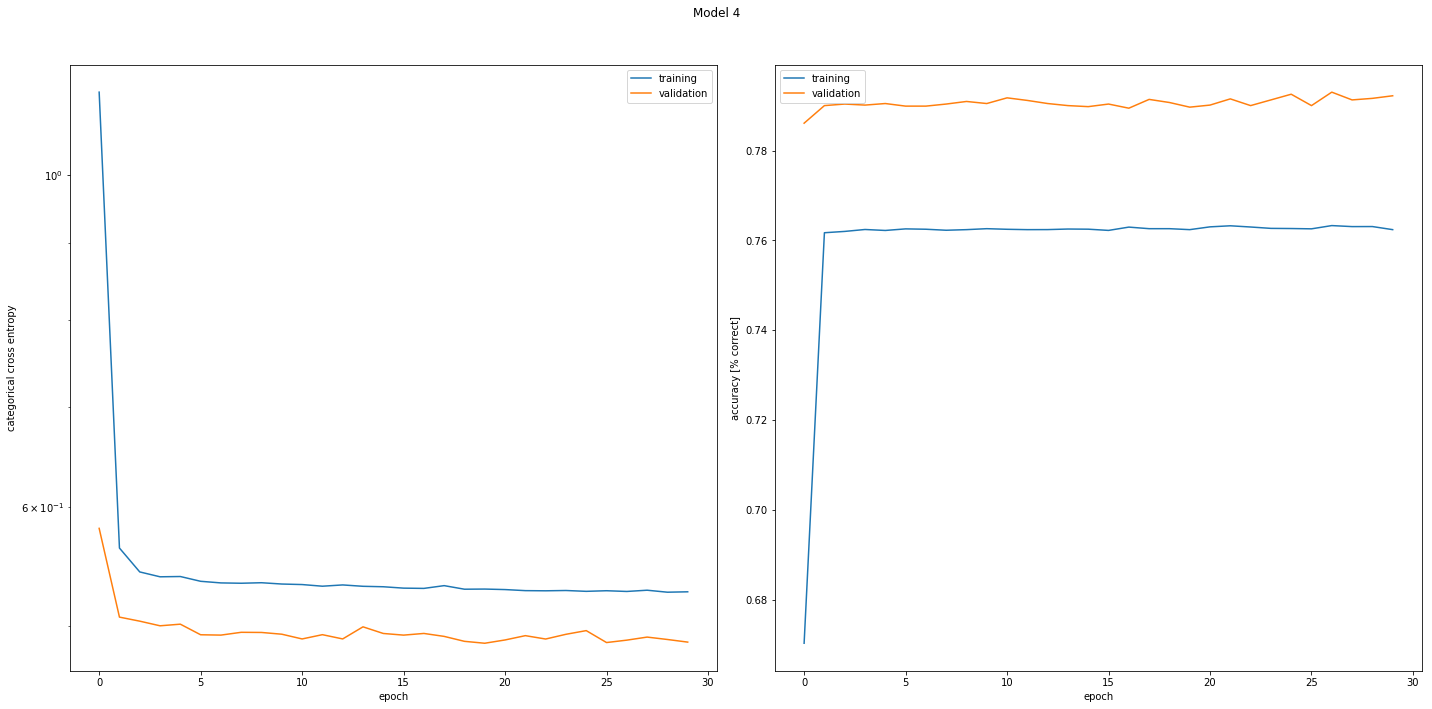

In [114]:
plot_history(history1,"Model 1")
plot_history(history2,"Model 2")
plot_history(history3,"Model 3")
plot_history(history4,"Model 4")
plt.show()

In [170]:
def plot_different_look_back(list):
    fig, ax = plt.subplots(2, figsize=(10, 20))
    linewidth = 3
    for elem in list:
        history,name,color = elem
        ax[0].plot(history.history['loss'], label = "Train loss for " + name,linestyle= ':',color = color , linewidth=linewidth)
        ax[0].plot(history.history['val_loss'], label = "Validation loss for " + name,linestyle= '-',color = color, linewidth=linewidth)
     
        ax[1].plot(history.history['acc'], label = "Train accuracy for" +  name,linestyle= ':',color = color, linewidth=linewidth)
        ax[1].plot(history.history['val_acc'], label = "Validation accuracy for" + name,linestyle= '-',color = color, linewidth=linewidth)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})
    ax[0].set_ylim([0.45, 0.8])
    ax[1].set_ylim([0.45, 0.8])
    plt.show()

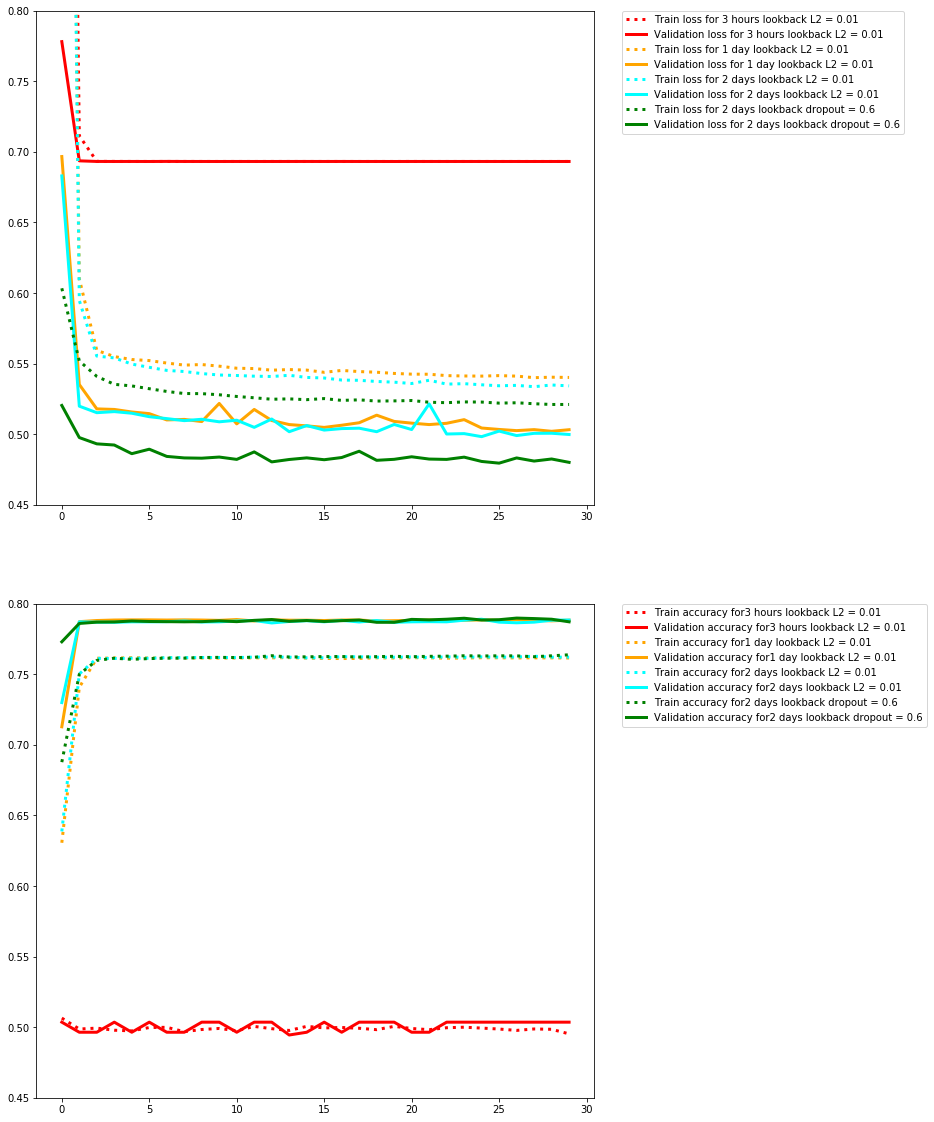

In [172]:
plot_different_look_back([(history_3hours,'3 hours lookback L2 = 0.01','red'),
                           (history_1day,'1 day lookback L2 = 0.01','orange'),
                           (history1,'2 days lookback L2 = 0.01','cyan'),
                           (history2,'2 days lookback dropout = 0.6','g')
                          ])